# Кластеризация документов

<img src='header_short.jpg'>

Покажем как можно кластеризовать набор документов с использованием Python. В данном случае нам интересно выявление скрытых структур в синопсисах 100 лучших фильмов всех времен (по версии IMDB).

## Содержание

* [Стоп-слова, стемминг, токенизация](#Стоп-слова,-стемминг,-токенизация)
* [Tf-idf и сходство документов](#Tf-idf-и-сходство-документов)
* [K-means кластеризация](#K-means-кластеризация)
* [Многомерное масштабирование](#Многомерное-масштабирование)
* [Визуализация кластеров документов](#Визуализация-кластеров-документов)
* [Иерархическая кластеризация документов](#Иерархическая-кластеризация-документов)

Импортируем все, что нужно

In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction

# nltk.download('stopwords')
# nltk.download('punkt')

# Стоп-слова, стемминг, токенизация

In [31]:
#импортируем 3 списка: titles, links and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
#проверяем что прочитаны только первые 100 штук
titles = titles[:100]

links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #вырезает HTML форматирование и конвертирует в юникод
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki
    
    
genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


In [3]:
print(titles[:10]) #первые 10 названий фильмов

['The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Raging Bull', 'Casablanca', "One Flew Over the Cuckoo's Nest", 'Gone with the Wind', 'Citizen Kane', 'The Wizard of Oz', 'Titanic']


In [33]:
synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #вырезает HTML форматирование и конвертирует в юникод
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [34]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
print(synopses[0][:200]) #первые 200 символов в первом синопсисе (for 'The Godfather')

 Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son,


In [35]:
# генерирует индекс для каждого элемента в корпусе (в данном случае это просто ранг), и он позже будет использоваться для оценки
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

In [36]:
stopwords = nltk.corpus.stopwords.words('english')

In [8]:
print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [9]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [10]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # отфильтровать все токены, не содержащие букв (например, числовые токены, знаки пунктуации)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # отфильтровать все токены, не содержащие букв (например, числовые токены, знаки пунктуации)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Проитерируемся по списку синопсисов для создания двух словарей: один со стемами и один с токенами.

In [11]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Используя эти два списка, создадим DataFrame со словарем из стемм в качестве индекса и токенизированными словами в качестве столбца. Преимущество этого заключается в том, что он обеспечивает эффективный способ поиска стеммы и возврата полного токена. Недостатком здесь является то, что стемм для токенов может быть несколько: стемма «бег» может быть связана с «бегом», «бегом», «бегом» и т. Д. Но для наших целей вполне сойдет первый попавшийся.

In [12]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

в словаре vocab_frame 312209 элементов

Вы заметите, что здесь явно есть некоторое повторение. При желании его можно убрать.

In [13]:
print(vocab_frame.head())

     words
plot  plot
edit  edit
edit  edit
edit  edit
on      on


## Tf-idf и сходство документов

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

Преобразуем список синопсисов *synopses* в матрицу tf-idf.

Чтобы получить матрицу Tf-idf, сначала посчитаем количество вхождений слов в каждом документе. Это преобразуется в матрицу термина документа (DTM). Это также называется термином частотная матрица. Пример DTM здесь справа.

Затем примените термин «частотно-обратное взвешивание частоты документа»: слова, которые часто встречаются в документе, но не часто в корпусе, получают больший вес, поскольку предполагается, что эти слова содержат большее значение по отношению к документу.

Несколько вещей, чтобы отметить о параметрах, которые я определяю ниже:

<UL>
<li> max_df: это максимальная частота в документах, которую данная функция может использовать в матрице tfi-idf. Если этот термин содержится в более чем 80% документов, он, вероятно, не имеет большого значения (в контексте кратких обзоров фильмов).
<li> min_idf: это может быть целое число (например, 5), и этот термин должен быть хотя бы в 5 рассматриваемых документах. Здесь я прохожу 0,2; срок должен быть не менее 20% документа. Я обнаружил, что если бы я допустил более низкое значение min_df, я бы в конечном итоге основывал кластеризацию на именах - например, «Майкл» или «Том» - это имена, найденные в нескольких фильмах, и в синопсисах эти имена используются часто, но имена не имеют никакого реального значения ,
<li> ngram_range: это просто означает, что я буду смотреть на униграммы, биграммы и триграммы. Смотрите [н-грамм] (http://en.wikipedia.org/wiki/N-gram)
</ UL>

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

# print(tfidf_matrix.shape)

c:\program files (x86)\python37-32\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 10.1 s


In [15]:
terms = tfidf_vectorizer.get_feature_names()

dist определяется как 1 - косинусное сходство каждого документа. Косинусное сходство измеряется по матрице tf-idf и может использоваться для генерации показателя сходства между документами (синопсами). Вычитая его из 1, получим косинусное расстояние, которое будем использовать для отображения документов на евклидовой (2-мерной) плоскости.

Обратите внимание, что с помощью dist можно оценить сходство любых двух или более синопсисов.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means кластеризация

Теперь самое интересное. Используя матрицу tf-idf, вы можете запустить множество алгоритмов кластеризации, чтобы лучше понять скрытую структуру в синопсах. Используем [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means инициализируется с заранее определенным количеством кластеров (в нашем случае 5). Каждое наблюдение назначается кластеру (назначение кластера), чтобы минимизировать сумму квадратов внутри кластера. Затем рассчитывается среднее значение кластерных наблюдений и используется как новый кластерный центроид. Затем наблюдения переназначаются на кластеры и центроиды, пересчитанные в итерационном процессе, пока алгоритм не достигнет сходимости.

Как оказалось, алгоритму потребовалось несколько прогонов чтобы достичь глобального оптимума, так как k-means чувствителен к достижению локальных оптимумумов.

In [17]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 871 ms


Используем **joblib.dump**, чтобы сохранить обученную модель и перезагрузить ее, переназначив метки классов, согласно кластерам.

In [18]:
from sklearn.externals import joblib

#joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

c:\program files (x86)\python37-32\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator KMeans from version pre-0.18 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The file 'doc_cluster.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  after removing the cwd from sys.path.


Здесь мы создаем словарь названий, рангов, синопсисов, кластеров и жанров.

Засунем этот словарь в Pandas DataFrame для удобства пользования.

In [19]:
import pandas as pd

films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [20]:
frame['cluster'].value_counts()

4    26
0    25
2    21
1    16
3    12
Name: cluster, dtype: int64

In [21]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    47.200000
1    58.875000
2    49.380952
3    54.500000
4    43.730769
Name: rank, dtype: float64

Обратите внимание, что **кластеры 4 и 0** имеют самый низкий рейтинг, что указывает на то, что они в среднем содержат фильмы, которые были оценены как «лучшие» в списке 100 лучших.

Вот некоторая причудливая индексация и сортировка для каждого кластера, чтобы определить, какие  n (пусть n = 6) слов - ближайшие к центроиду кластера. Это дает хорошее представление о главной теме кластера.

In [22]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'family', b'home', b'mother', b'war', b'house', b'dies',

Cluster 0 titles: Schindler's List, One Flew Over the Cuckoo's Nest, Gone with the Wind, The Wizard of Oz, Titanic, Forrest Gump, E.T. the Extra-Terrestrial, The Silence of the Lambs, Gandhi, A Streetcar Named Desire, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, The Pianist, The Exorcist, Out of Africa, Good Will Hunting, Terms of Endearment, Giant, The Grapes of Wrath, Close Encounters of the Third Kind, The Graduate, Stagecoach, Wuthering Heights,

Cluster 1 words: b'police', b'car', b'killed', b'murders', b'driving', b'house',

Cluster 1 titles: Casablanca, Psycho, Sunset Blvd., Vertigo, Chinatown, Amadeus, High Noon, The French Connection, Fargo, Pulp Fiction, The Maltese Falcon, A Clockwork Orange, Double Indemnity, Rebel Without a Cause, The Third Man, North by Northwest,

Cluster 2 words: b'father', b'new', b'york', b'new', b'brothers', b'apartments',

Clust

# Многомерное масштабирование

Вот некоторый код для преобразования матрицы dist в двумерный массив с использованием многомерного масштабирования. Другой вариант - использовать PCA (анализ главных компонент).

In [37]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# 2 компоненты, т.к. мы хотим отобразить точки на двухмерной плоскости
# "precomputed" потому что мы задаем матрицу расстояний
# указываем `random_state` для воспроизведения графика.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [24]:
#вырезать из текста любые собственные существительные (NNP) или собственные имена во множественном числе (NNPS)
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Визуализация кластеров документов

Сначала определим несколько словарей для перехода от номера кластера к цвету и к имени кластера. Имена кластеров основаны на словах, которые ближе всего к центроиду каждого кластера.

In [38]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

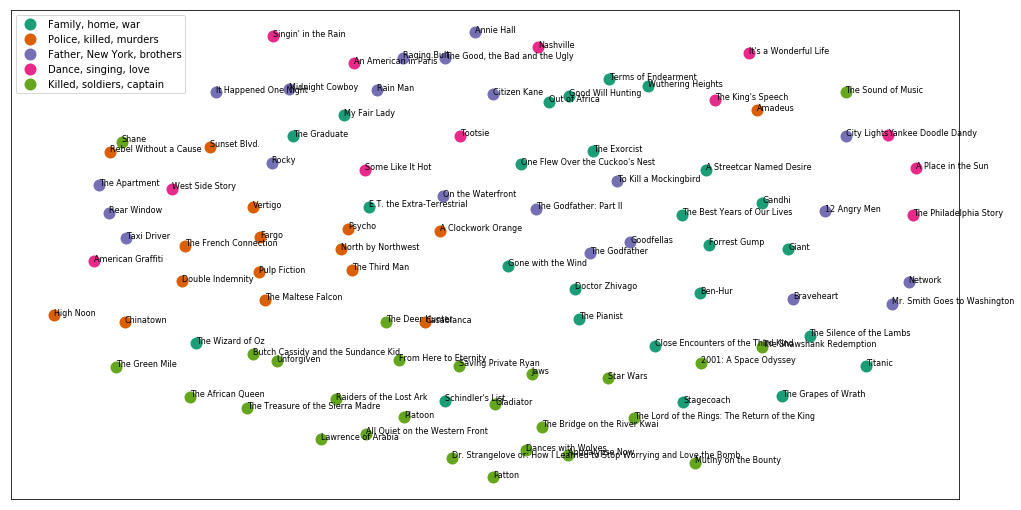

In [44]:
%matplotlib inline

df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#сгруппируем по кластерам
groups = df.groupby('label')


# настроим график
fig, ax = plt.subplots(figsize=(17, 9)) # установим размер
ax.margins(0.05) # Необязательно

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',       
        which='both',    
        left=False,     
        top=False,        
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#добавить метку с названия фильма в позиции x,y
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#plt.savefig('clusters_small_noaxes.png', dpi=200)

plt.close()

# Иерархическая кластеризация документов

Теперь, когда мы успешно кластеризовали документы с помощью k-средних, попробуем другой алгоритм кластеризации. Я выбрал алгоритм кластеризации Уорда, потому что он предлагает иерархическую кластеризацию. Кластеризация Уорда - это метод агломерационной кластеризации, означающий, что на каждом этапе пара кластеров с минимальным межкластерным расстоянием объединяется. Используем предварительно вычисленную матрицу косинусных расстояний (dist), чтобы вычислить матрицу linkage_matrix, которую затем построим в виде дендрограммы.

Обратите внимание, что этот метод вернул 3 основных кластера, при этом самый большой кластер был разделен на 4 основных подкластера.

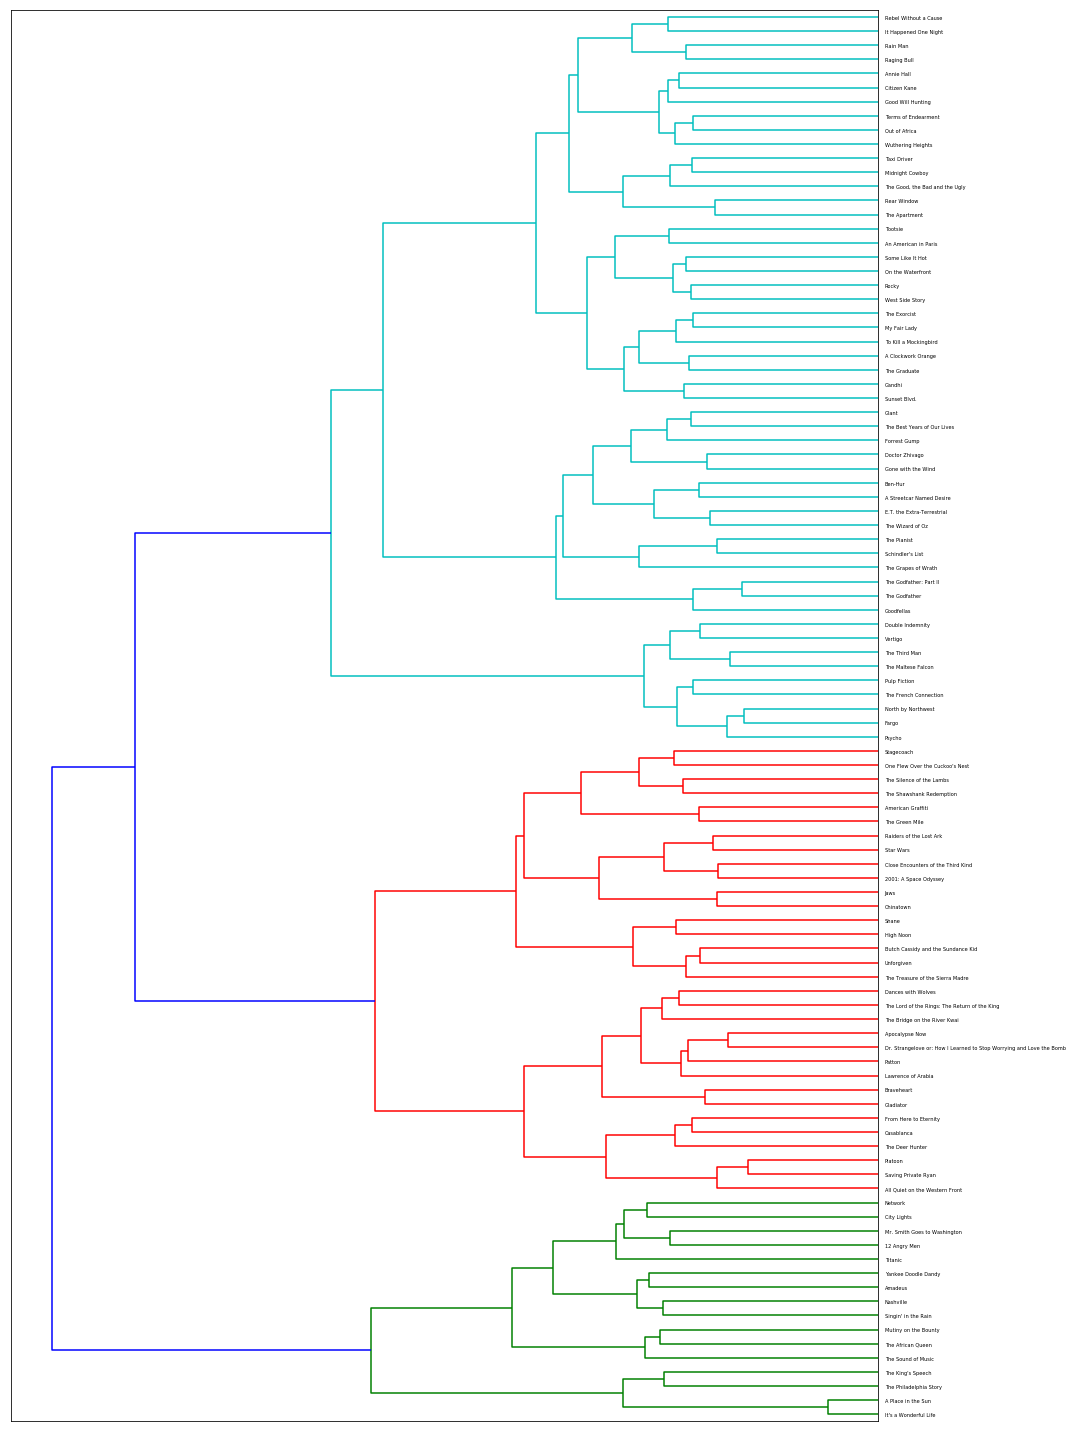

In [48]:
from scipy.cluster.hierarchy import ward, dendrogram, linkage

# linkage_matrix = linkage(tfidf_matrix,'ward')
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, orientation="left", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.tight_layout()

plt.savefig('ward_clusters.png', dpi=200)

In [29]:
plt.close()

### Подсчет кластеров

Основываясь на результатах кластеризации, я использовал средний ранг из списка IMDB для оценки кластеров (чем ниже, тем лучше).

<table>
    <tr>
    <th>Rank</th>
    <th>Cluster</th>
    <th>Score</th>
    <th>Count</th>
  </tr>
  <tr>
    <td>1</td>
    <td>Killed, soldiers, captain</td>
    <td>43.7</td>
    <td>26</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Family, home, war</td>
    <td>47.2</td>
    <td>25</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Father, New York, brothers</td>
    <td>49.4</td>    
    <td>21</td>
  </tr>
  <tr>
    <td>4</td>
    <td>Dance, singing, love</td>
    <td>54.5</td>    
    <td>12</td>
  </tr>
  <tr>
    <td>5</td>
    <td>Police, killed, murders</td>
    <td>58.8</td>    
    <td>16</td>
  </tr>
</table>